# Let's build an ocean wave model

This notebook guides you through the development of a minimal yet complete spectral ocean wave model.

The model, and especially its source functions, are largely based on the 
[University of Miami Wave Model (UMWM)](https://umwm.org).
However, what's simplified here relative to UMWM is the following:

* Omnidirectional waves (1-D spectrum)--this removes any directional wave effects.
* 1-D in geographical space--now that we work with omnidirectional waves, what the heck do we need 2-D space for?
* No diagnostic tail--more on this later.
* No refraction--waves have nowhere to turn in 1-D space.
* No bottom friction effects, though we may easily add later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rc('font', size=16)

## Define frequency values

At any point in space, we'll keep track of waves of different wavelengths and frequencies all at once.
To do this, we'll define the frequency values for which our model will solve for wave energy.

It's common practice to define the frequency in a logarithmic spacing, such that:

$$
f = [f_1, ..., f_{n-1}, f_n, f_{n+1}, ..., f_N]
$$

$$
f_{n+1} = af_n
$$

where $a$ is the frequency spacing factor.

Why define the values of frequency rather than wavenumber? 
Frequency is the more natural choice because it's independent of water depth.
On the other side, wavenumber varies with depth.

There are a few different options we can use to define the frequency space:

* Define $f_1$, $f_N$, and $N$, which would determine the spacing $a$
* Define $f_1$, $f_N$, and $a$, which would determine the total number of frequency bins $N$
* Define $f_1$, $N$, and $a$, which would determine the maximum frequecy $f_N$

A common choice in wave modeling is to use $a = 1.1$.

For simplicity, we'll use the first option, and set $f_1$, $f_N$, and $N$. 

In [2]:
def frequency_logspace(fmin: float, fmax: float, num_frequencies: int) -> np.ndarray:
    """Returns an array of frequencies distributed in log-space
    in the range of [fmin, fmax] with num_frequencies increments."""
    return np.logspace(np.log10(fmin), np.log10(fmax),  num=num_frequencies, endpoint=True)

This function will take floats `fmin` and `fmax`, and an integer `num_frequencies`, 
and return a NumPy array with frequencies in a logarithmic spacing.
It's just a thin wrapper around `np.logspace`, however it's helpful to have it because 
we now don't have to worry about taking a logarithm of `fmin` and `fmax` and specifying `endpoint=True`. 

Let's now set the values of these parameters:

In [3]:
fmin = 0.1 # Hz
fmax = 20 # Hz
num_frequencies = 50

Let's call the `frequency_logspace` function and store it into a variable, so we can reuse it later:

In [4]:
f = frequency_logspace(fmin, fmax, num_frequencies)

We can now look at the specific values to make sure we got $f_1$, $f_N$, $N$, and $a$ that we expected:

In [5]:
f[0], f[-1], f.size, f[1] / f[0]

(0.1, 20.000000000000004, 50, 1.1141913841958426)

Text(0, 0.5, 'Frequency [Hz]')

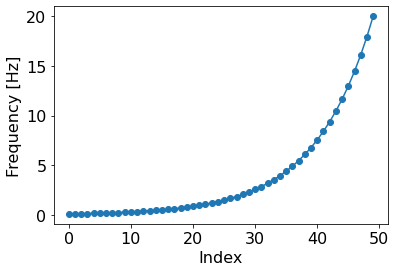

In [6]:
plt.plot(f, marker='o')
plt.xlabel('Index')
plt.ylabel('Frequency [Hz]')

## Define the physical space

In [7]:
xmin = 0
xmax = 10
num_grid_points = 11

In [8]:
x = np.linspace(xmin, xmax, num_grid_points, endpoint=True)

In [9]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

Text(0, 0.5, 'Fetch [m]')

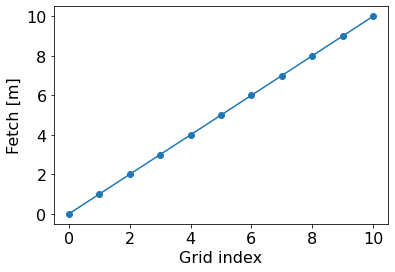

In [10]:
plt.plot(x, marker='o')
plt.xlabel('Grid index')
plt.ylabel('Fetch [m]')

## Create a 2-D frequency-space array

We now have a frequency array with 50 frequency bins, and a space array with 11 grid points. 
Let's merge them and make each a 2-D array so that they have the same shape: (11, 50). 

Why would you want to do this? 
As you'll see very soon, we'll carry out most of our calculations for the whole grid and frequency range at once.
NumPy is happiest when it can zip through whole-array operations, very much like Fortran.
This is because for whole-array operations, NumPy can dispatch the whole calculation to a compiled C or Fortran
code under the hood.
In contrast, if you resort to `for`-loops, you'd be making many small calls like this, which impacts performance.

To convert frequency and space arrays into equivalent 2-D arrays of same shape, we can use `np.meshgrid`, 
made exactly for this purpose:

In [11]:
f, x = np.meshgrid(f, x)

`np.meshgrid` takes two 1-D arrays as arguments. 
The first argument it tiles exactly as many times as there are elements in the second array.
The second argument it tiles exactly as many times as there are elements in the first array.
The result are two 2-D arrays.
In our call above, we update `f` and `x` arrays in place.

Let's check that it worked:

In [12]:
f.shape, x.shape

((11, 50), (11, 50))

Text(0.5, 1.0, 'Fetch [m]')

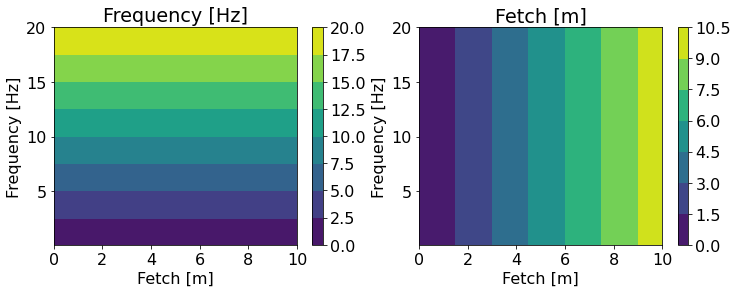

In [13]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
cf1 = ax1.contourf(x, f, f)
plt.colorbar(cf1, ax=ax1)
cf2 = ax2.contourf(x, f, x)
plt.colorbar(cf2, ax=ax2)
for ax in [ax1, ax2]:
    ax.set_xlabel('Fetch [m]')
    ax.set_ylabel('Frequency [Hz]')
ax1.set_title('Frequency [Hz]')
ax2.set_title('Fetch [m]')

## Computing the wavenumber from frequency

The dispersion relationship for gravity-capillary water waves in arbitrary depth is:

$$
\omega^2 = \left( gk + \dfrac{\sigma k^3}{\rho_w} \right) \tanh \left( kd \right)
$$

This equation relates angular frequency $\omega = 2 \pi f$ to wavenumber $k$.
This relationship is non-linear and has no analytic solution.
To determine $k$ from frequency, we'll need to solve it numerically.

Before we do so, let's define the physical parameters that we'll need for the calculation:

* Gravitational acceleration $g$ [$m/s^2$]
* Surface tension $\sigma$ [$N/m$]
* Water density $\rho_w$ [$kg/m^3$]
* Water depth $d$ [$m$]

Let's define these parameters now:

In [14]:
grav_accel = 9.8
surface_tension = 0.07
water_density = 1e3
water_depth = 1e3

In [15]:
def wavenumber(frequency, water_depth, grav=9.8, surface_tension=0.074, water_density=1e3):
    """Solves the dispersion relationship for wavenumber 
    using a Newton-Raphson iteration method."""
    frequency_nondim = 2 * np.pi * np.sqrt(water_depth / grav) * frequency
    k = frequency_nondim**2
    surface_tension_nondim = surface_tension / (grav_accel * water_density * water_depth**2)
    count = 0
    while True:
        t = np.tanh(k)
        dk = - (frequency_nondim**2 - k * t * (1 + surface_tension_nondim * k**2)) \
           / (3 * surface_tension_nondim * k**2 * t + t + k * (1 + surface_tension_nondim * k**2) * (1 - t**2))
        k -= dk
        count += 1
        if count > 100:
            break
    return k / water_depth

Text(0.5, 1.0, 'Dispersion relationship')

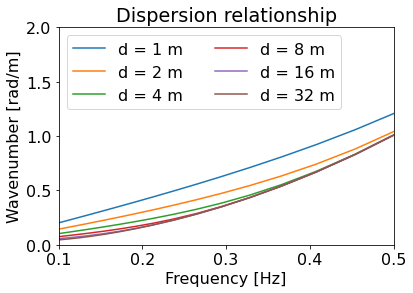

In [16]:
plt.plot(f[0,:], wavenumber(f, 1)[0,:], label='d = 1 m')
plt.plot(f[0,:], wavenumber(f, 2)[0,:], label='d = 2 m')
plt.plot(f[0,:], wavenumber(f, 4)[0,:], label='d = 4 m')
plt.plot(f[0,:], wavenumber(f, 8)[0,:], label='d = 8 m')
plt.plot(f[0,:], wavenumber(f, 16)[0,:], label='d = 16 m')
plt.plot(f[0,:], wavenumber(f, 32)[0,:], label='d = 32 m')
plt.legend(loc='upper left', ncol=2)
plt.xlim(0.1, 0.5)
plt.ylim(0, 2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Wavenumber [rad/m]')
plt.title('Dispersion relationship')

In [17]:
depth = water_depth * np.ones(x.shape)

In [18]:
def phase_speed(frequency, wavenumber):
    """Returns the phase speed of a wave given input frequency and wavenumber."""
    return 2 * np.pi * frequency / wavenumber

In [19]:
def group_speed(frequency, wavenumber, water_depth, water_density=1e3, surface_tension=0.074, grav=9.8):
    """Returns the group speed of a wave given input frequency, wavenumber, and water depth."""
    cp = phase_speed(frequency, wavenumber)
    kd = wavenumber * water_depth
    sigma_k2 = surface_tension * wavenumber**2
    return cp * (0.5 + kd / np.sinh(kd) + sigma_k2 / (water_density * grav_accel * sigma_k2))

In [20]:
k = wavenumber(f, depth)

Text(0.5, 1.0, 'Phase and group speed')

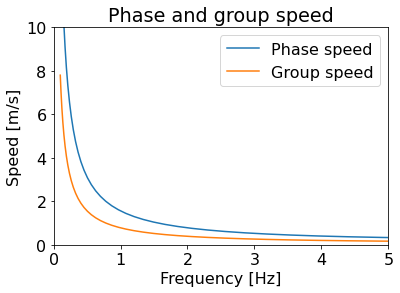

In [21]:
plt.plot(f[0,:], phase_speed(f, k)[0,:], label='Phase speed')
plt.plot(f[0,:], group_speed(f, k, depth)[0,:], label='Group speed')
plt.legend()
plt.xlim(0, 5)
plt.ylim(0, 10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Speed [m/s]')
plt.title('Phase and group speed')

## Wind input source function

Our first source function is defined as:

$$
S_{in} = \mathcal{A} \dfrac{\rho_a}{\rho_w} \left( U - c_p \right) \left| U - c_p \right) \dfrac{\omega k}{g}
$$

In [22]:
def source_input(wind_speed, frequency, wavenumber, phase_speed, sheltering_coefficient=0.11, 
                 air_density=1.2, water_density=1e3, current=0):
    wind_speed_relative = wind_speed - phase_speed - current
    s_in = sheltering_coefficient * wind_speed_relative * np.abs(wind_speed_relative)
    s_in *= air_density / water_density * 2 * np.pi * frequency * wavenumber / grav_accel
    return s_in

In [23]:
cp = phase_speed(f, k)

Text(0.5, 1.0, '$\\dfrac{\\rho_a}{\\rho_w}\\mathcal{A}(U_z - c_p)|U_z - c_p| \\dfrac{\\omega k}{g}$')

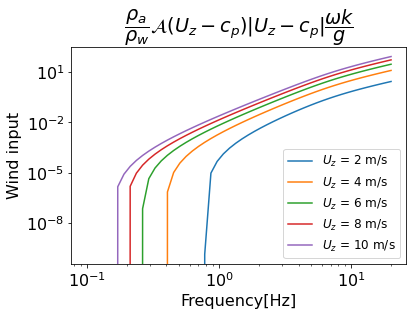

In [24]:
for wspd in range(2, 12, 2):
    plt.loglog(f[0,:], source_input(wspd, f, k, cp)[0,:], label=r'$U_z$ = %s m/s' % wspd)
plt.legend(prop={'size': 12})
plt.xlabel('Frequency[Hz]')
plt.ylabel('Wind input')
plt.title(r'$\dfrac{\rho_a}{\rho_w}\mathcal{A}(U_z - c_p)|U_z - c_p| \dfrac{\omega k}{g}$')

In [25]:
cg = group_speed(f, k, depth)
dk = 2 * np.pi * f / cg

Text(0.5, 1.0, 'Wavenumber spacing [rad/m]')

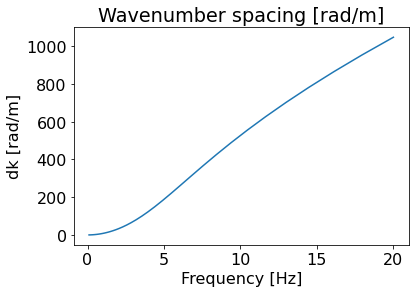

In [26]:
plt.plot(f[0,:], dk[0,:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('dk [rad/m]')
plt.title('Wavenumber spacing [rad/m]')

## Mean squared slope

Mean squared slope is an integral quantity that tells us how steep is the wave field, 
considering every single wave component:

$$
\chi^2 = \int_{k_{min}}^{k_{max}} F(k) k^2 dk
$$

In [27]:
def mean_squared_slope(spectrum_k, k, dk):
    return np.sum(spectrum_k * k**2 * dk, axis=1)

$$
\chi^2 \left (k_L \right) = \int_{k_L}^{k_{max}} F(k) k^2 dk
$$

In [28]:
def mean_squared_slope_long(spectrum_k, k, dk):
    return np.cumsum(spectrum_k * k**2 * dk, axis=1)

In [29]:
Fk = np.ones(k.shape) * 1e-15

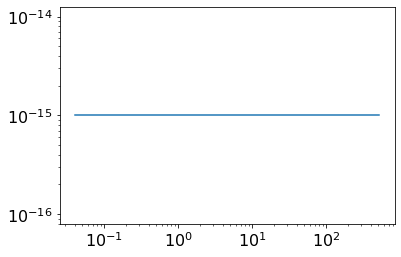

In [30]:
plt.loglog(k[0,:], Fk[0,:])

Text(0.5, 1.0, 'Mean squared slope of all waves\n longer than wavenumber')

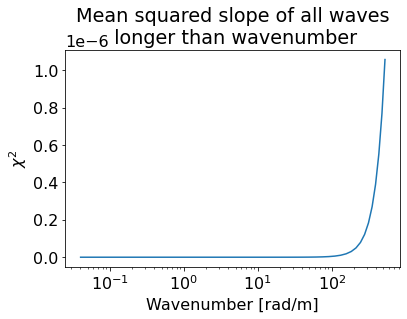

In [31]:
plt.semilogx(k[0,:], mean_squared_slope_long(Fk, k, dk)[0,:])
plt.xlabel('Wavenumber [rad/m]')
plt.ylabel(r'$\chi^2$')
plt.title('Mean squared slope of all waves\n longer than wavenumber')

## Saturation spectrum

$$
B(k) = F(k) k^4
$$

In [32]:
def saturation_spectrum(spectrum_k, k):
    return spectrum_k * k**4

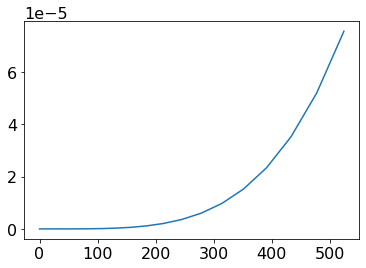

In [33]:
plt.plot(k[0,:], saturation_spectrum(Fk, k)[0,:])

## Wave dissipation source function

$$
S_{ds} = b \omega \left( 1 + \chi^2 \left[ k_{L} \right) \right]^2 B_k^N
$$

In [34]:
def source_dissipation(spectrum_k, f, k, dk, dissipation_coefficient=42, dissipation_power=2.4, mss_coefficient=120):
    omega = 2 * np.pi * f
    if mss_coefficient > 0:
        mss = mean_squared_slope_long(spectrum_k, k, dk) 
    else:
        mss = np.zeros(k.shape)
    mss_effect = (1 + mss_coefficient * mss)**2
    B_k = saturation_spectrum(spectrum_k, k)
    return dissipation_coefficient * omega * mss_effect * B_k**dissipation_power

In [35]:
def wind_wave_balance(source_input, frequency, wavenumber, dissipation_coefficient=42, 
                      dissipation_power=2.4, mss=0, mss_coefficient=120):
    """Returns the spectrum for which the dissipation is balanced by input."""
    omega = 2 * np.pi * frequency
    mss_effect = (1 + mss_coefficient*mss)**2
    Fk = (source_input / (omega * dissipation_coefficient * mss_effect))**(1 / dissipation_power) / wavenumber**4
    Fk[np.isnan(Fk)] = 0
    return Fk

In [36]:
Fk = wind_wave_balance(source_input(10, f, k, cp), f, k)

Text(0.5, 1.0, 'Balance between input and dissipation')

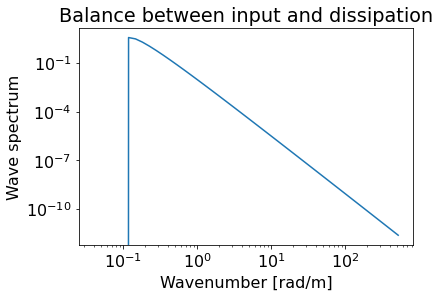

In [37]:
plt.loglog(k[0,:], Fk[0,:])
plt.xlabel('Wavenumber [rad/m]')
plt.ylabel('Wave spectrum')
plt.title('Balance between input and dissipation')

Text(0.5, 1.0, 'Mean squared slope of all waves\n longer than wavenumber')

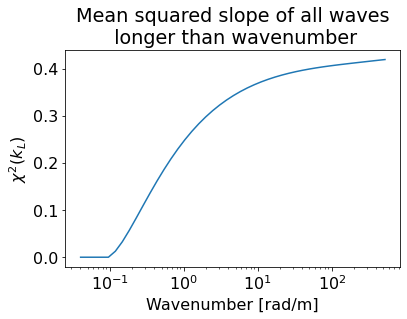

In [38]:
plt.semilogx(k[0,:], mean_squared_slope_long(Fk, k, dk)[0,:])
plt.xlabel('Wavenumber [rad/m]')
plt.ylabel(r'$\chi^2 (k_L)$')
plt.title('Mean squared slope of all waves\n longer than wavenumber')

In [39]:
def source_wave_interactions(spectrum_k, k, dk, snl_coefficient=1):
    Snl = np.zeros((k.shape))
    Snl[:,:-1] = snl_coefficient * np.diff(spectrum_k, axis=1) / dk[:,1:]
    return Snl

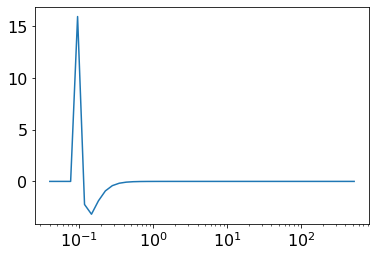

In [40]:
plt.semilogx(k[0,:], source_wave_interactions(Fk, k, dk)[0,:])

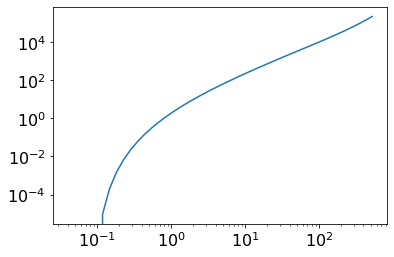

In [41]:
plt.loglog(k[0,:], source_dissipation(Fk, f, k, dk)[0,:])

In [42]:
def advect(q, c, x):
    """Advects quantity q with advective velocity c in space x."""
    res = np.zeros(q.shape)
    res[1:,:] = np.diff(q, axis=0) / np.diff(x, axis=0)
    res[0,:] = q[0,:] / (x[1,:] - x[0,:])
    return res * c

In [43]:
def significant_wave_height(spectrum_k, dk):
    return 4 * np.sqrt(np.sum(spectrum_k * dk, axis=1))

In [44]:
def mean_wave_period(spectrum_k, f):
    return np.sum(spectrum_k, axis=1) / np.sum(spectrum_k * f, axis=1)

In [45]:
def dominant_wave_period(spectrum_k, f):
    return np.sum(spectrum_k**4, axis=1) / np.sum(spectrum_k**4 * f, axis=1)

In [46]:
def form_drag(source_input, spectrum_k, phase_speed, dk, water_density=1e3, grav=9.8):
    return water_density * grav * np.sum(source_input * spectrum_k * dk / phase_speed, axis=1)

In [47]:
def integrate(Fk_init, f, k, cp, cg, x, wspd, duration, dt, mss_coefficient=120, snl_coefficient=1):
    time = []
    num_time_steps = int(duration / dt)
    num_grid_points = k.shape[0]
    
    swh = np.zeros((num_time_steps, num_grid_points))
    mwp = np.zeros((num_time_steps, num_grid_points))
    dwp = np.zeros((num_time_steps, num_grid_points))
    mss = np.zeros((num_time_steps, num_grid_points))
    tau = np.zeros((num_time_steps, num_grid_points))
    
    dk = 2 * np.pi * f / cg
    Fk = 1. * Fk_init[:]
    
    for n in range(num_time_steps):
        time.append(n * dt)
        if n % 1000 == 0: print(n, '/', num_time_steps)
        
        Sin = source_input(wspd, f, k, cp)
        Sds = source_dissipation(Fk, f, k, dk, mss_coefficient=mss_coefficient)
        Snl = source_wave_interactions(Fk, k, dk, snl_coefficient=snl_coefficient)
        adv = advect(Fk, cg, x)
        Fk *= np.exp(dt * (Sin - Sds))
        Fk += dt * Snl
        Fk -= dt * adv
        
        swh[n,:] = significant_wave_height(Fk, dk)
        mwp[n,:] = mean_wave_period(Fk, f)
        dwp[n,:] = dominant_wave_period(Fk, f)
        mss[n,:] = mean_squared_slope(Fk, k, dk)
        tau[n,:] = form_drag(Sin, Fk, cp, dk)
        
    time = np.array(time)
    return time, swh, mwp, dwp, mss, tau, Fk

In [48]:
Fk_init = wind_wave_balance(source_input(0.8, f, k, cp), f, k)
time, swh, mwp, dwp, mss, tau, Fk = integrate(Fk_init, f, k, cp, cg, x, 5, 60, 0.01)

0 / 6000
1000 / 6000
2000 / 6000
3000 / 6000
4000 / 6000
5000 / 6000


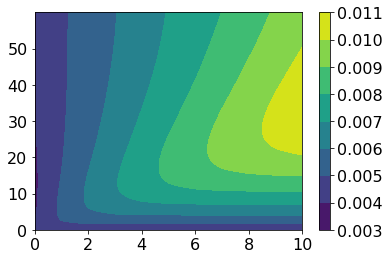

In [49]:
plt.contourf(x[:,0], time, swh)
plt.colorbar()

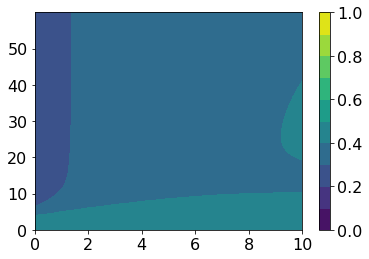

In [50]:
plt.contourf(x[:,0], time, dwp, np.arange(0, 1.1, 0.1))
plt.colorbar()

Text(0, 0.5, '$F_k$')

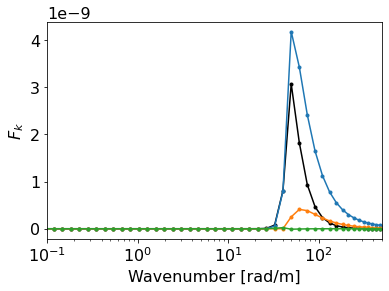

In [51]:
plt.semilogx(k[0,:], Fk[0,:], marker='.', color='k')
plt.semilogx(k[0,:], Fk[0,:] * source_input(10., f, k, cp)[0,:], marker='.')
plt.semilogx(k[0,:], Fk[0,:] * source_dissipation(Fk, f, k, dk)[0,:], marker='.')
plt.semilogx(k[0,:], source_wave_interactions(Fk, k, dk)[0,:], marker='.')
plt.xlim(1e-1, 5e2)
plt.xlabel('Wavenumber [rad/m]')
plt.ylabel(r'$F_k$')